In [21]:
pip install tld

Note: you may need to restart the kernel to use updated packages.


In [22]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

# Exploratory Data Analysis

In [23]:
data = pd.read_csv('malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [25]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [26]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

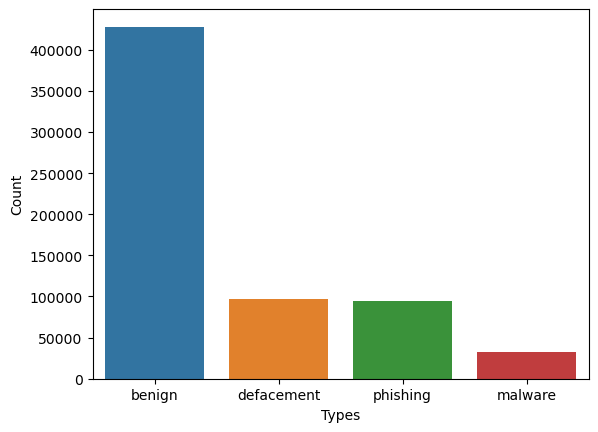

In [27]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

# Data cleaning and Feature Extraction

In [28]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [78]:
data.head(10)

,url,type,Category,url_len,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,Shortening_Service,having_ip_address
0,br-icloud.com.br,phishing,1,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,buzzfil.net,0,0,16,0,2,...,0,0,0,1,1,0,1,93,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,espn.go.com,0,0,1,0,2,...,0,0,0,0,0,0,4,31,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,yourbittorrent.com,0,1,2,1,1,...,0,0,0,0,0,0,0,40,1,0
8,http://pashminaonline.com/pure-pashminas,defacement,1,40,pashminaonline.com,0,0,1,0,1,...,0,0,0,1,1,0,0,34,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,allmusic.com,0,0,4,0,1,...,0,0,0,0,0,0,5,33,0,0


In [30]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

In [31]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [32]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [33]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [34]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [35]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [36]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [37]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [38]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

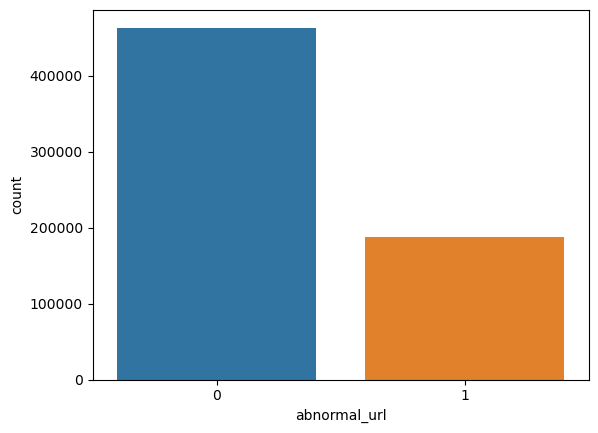

In [39]:
sns.countplot(x='abnormal_url', data=data);

In [40]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [41]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

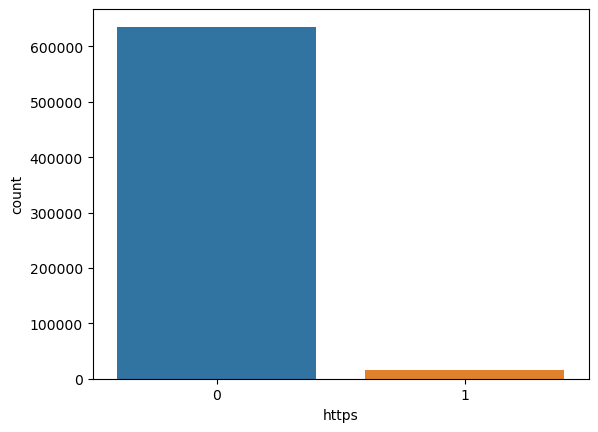

In [42]:
sns.countplot(x='https', data=data);

In [43]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [44]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [45]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [46]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [47]:
def Shortening_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [48]:
data['Shortening_Service'] = data['url'].apply(lambda x: Shortening_Service(x))

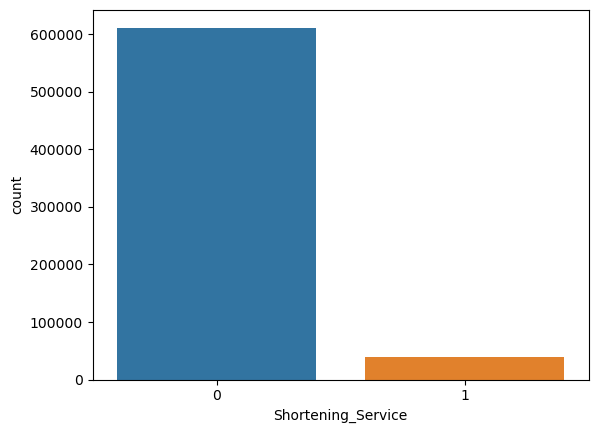

In [49]:
sns.countplot(x='Shortening_Service', data=data);

In [50]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [51]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [52]:
data['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

C:\Users\dalwa\AppData\Local\Temp\ipykernel_3620\1379355153.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), linewidths=.5)


<AxesSubplot: >

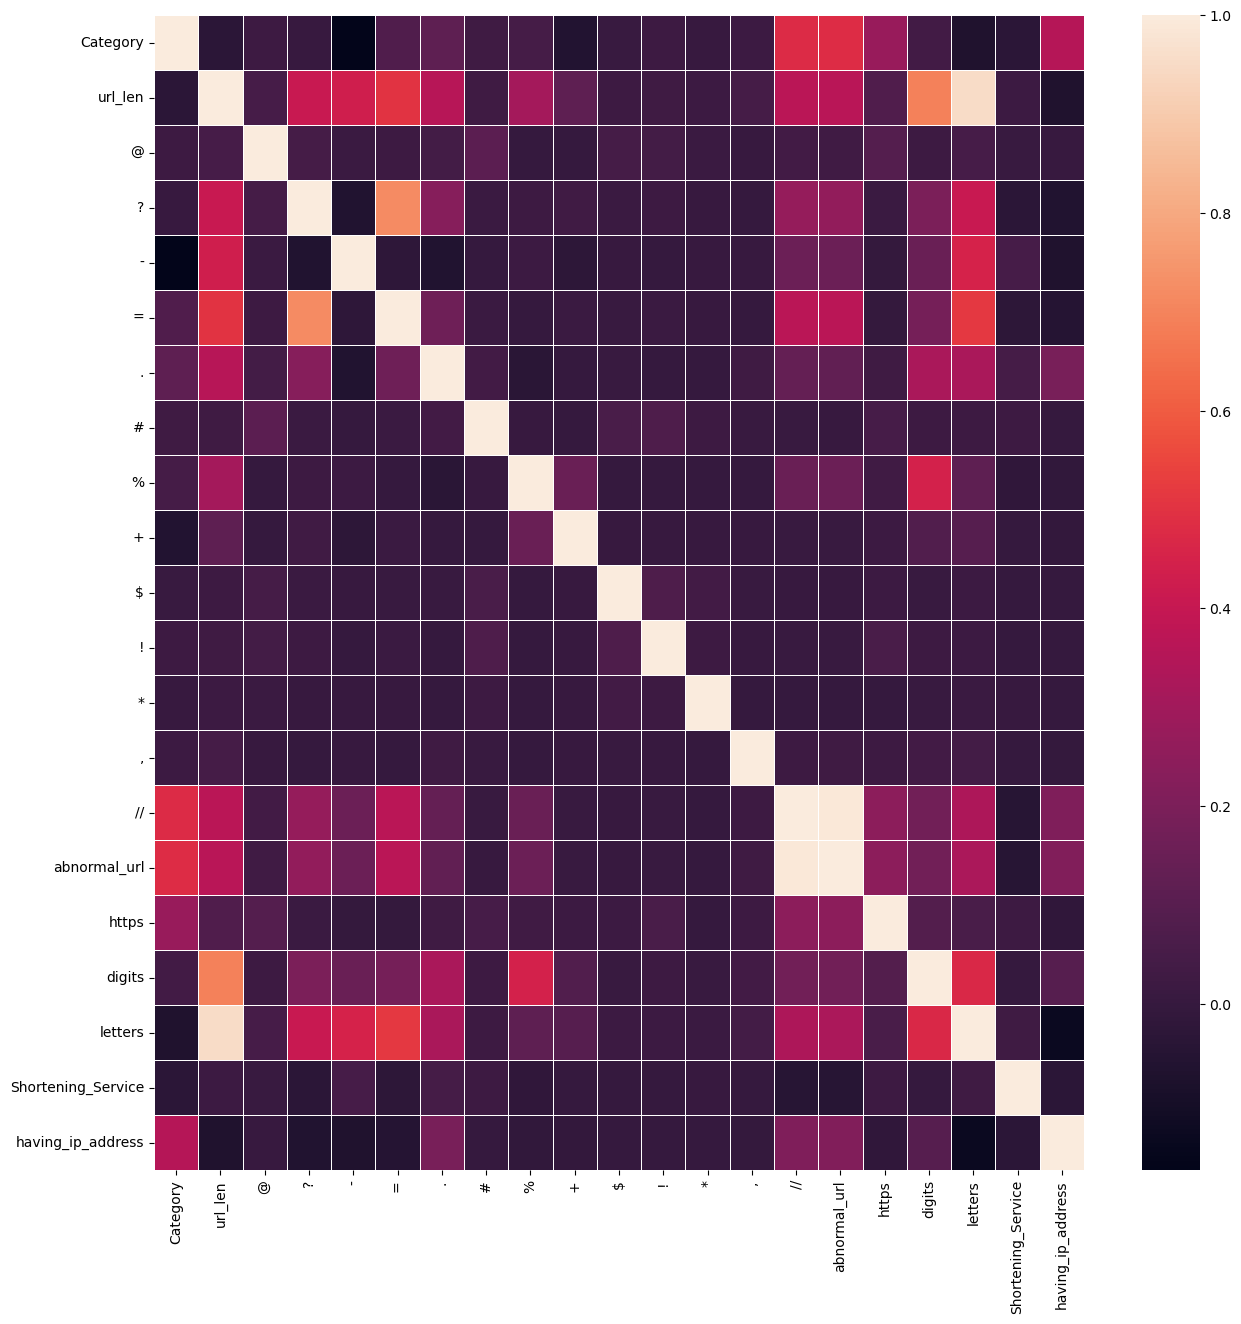

In [53]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [54]:
def categoryChanger(catType):
    if(catType>0):
        return 1
    else:
        return 0

In [55]:
data['Category'] = data['Category'].apply(lambda i: categoryChanger(i))

In [56]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [57]:
pd.value_counts(data['Category'])

0    428103
1    223088
Name: Category, dtype: int64

# Creating Our Model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [59]:


model = keras.Sequential([
    layers.BatchNormalization(input_shape=[20]),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1

In [60]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [61]:
model.fit(X_train, y_train, verbose=1, epochs=2)

Epoch 1/2
16280/16280 [==============================] - 240s 14ms/step - loss: 0.3285 - binary_accuracy: 0.8622
Epoch 2/2
16280/16280 [==============================] - 262s 16ms/step - loss: 0.3150 - binary_accuracy: 0.8677


We can see that our model is fairly accurate! Thats all for today folks!

In [63]:
model.save('urlmodel.h5')

In [96]:
newval=(model.predict(X_train[:20]))

1/1 [==============================] - 0s 194ms/step


In [101]:
np.round(newval*100,2)

array([[  0.64],
       [ 16.08],
       [  2.96],
       [  1.2 ],
       [  1.23],
       [ 99.34],
       [ 29.24],
       [100.  ],
       [ 22.82],
       [ 99.25],
       [ 99.92],
       [ 18.83],
       [  1.91],
       [ 99.62],
       [ 99.83],
       [  0.67],
       [ 81.16],
       [ 12.16],
       [ 99.19],
       [  6.03]], dtype=float32)